# Generate AIS reception and gap events datasets

This notebook is a wrapper file for producing a complete set of results and inputs for Welch et al. (2021). It contains code for the following: 

1. Generate raw AIS gap events greater than 12 hours
2. Generate monthly AIS reception maps
3. Detect suspected AIS disabling events

## Setup

### Packages

In [16]:
# Modules
import os
import pandas as pd
import numpy as np
import pandas_gbq
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
import time
from google.cloud import bigquery
from jinja2 import Template

import pyseas
import pyseas.maps
import pyseas.maps.rasters
import pyseas.styles
import pyseas.cm

# project specific functions
import utils 

%load_ext autoreload
%load_ext google.cloud.bigquery
%autoreload 2

# BigQuery client
client = bigquery.Client()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/miniconda3/envs/gfw/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/miniconda3/envs/gfw/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about servic

### Inputs & Parameters

In [2]:
# Input BQ datasets/tables
gfw_research = 'gfw_research'
gfw_research_precursors = 'gfw_research_precursors'
proj_dataset = 'proj_ais_gaps_catena'
destination_dataset = 'scratch_tyler'

pipeline_version = 'v20201001'
pipeline_table = 'pipe_{}'.format(pipeline_version)
segs_table = 'pipe_{}_segs'.format(pipeline_version)
vi_version = 'v20210301'
vd_version = 'v20210601'

# Output tables version
output_version = 'v20210722'
create_tables = True

# Date range
start_date = date(2017,1, 1)
end_date = date(2020,12, 31)

# Min gap hours
min_gap_hours = 6

Generate list of dates to produce for analysis.

In [3]:
# Generate list of dates to run
dates_to_run = utils.daterange(start_date, end_date)
tp = []
for dt in dates_to_run:
    tp.append(dt.strftime("%Y-%m-%d"))

# AIS Gaps dataset

Generate a dataset of AIS gaps for time range. This involves running the following query sequence (queries in the `gaps` subdirectory):
1. AIS off events: `ais_off_on_events.sql.j2` with `event` parameter set to `'off'`
2. AIS on events: `ais_off_on_events.sql.j2` with `event` parameter set to `'on'`
3. AIS gap events: Stitch off and on events together into gap events using `ais_gap_events.sql.j2`

### Create tables

First, create empty tables for all three tables.

In [4]:
# Destination tables
off_events_table = 'ais_off_events_{}'.format(output_version)
on_events_table = 'ais_on_events_{}'.format(output_version)
gap_events_table = 'ais_gap_events_{}'.format(output_version)

Create tables for off/on events.

In [47]:
if create_tables:
    # Off events
    utils.make_bq_partitioned_table(destination_dataset, off_events_table)
    # On events
    utils.make_bq_partitioned_table(destination_dataset, on_events_table)

### Off events

Generate off events

In [48]:
# Store commands
cmds = []
for t in tp:
    cmd = utils.make_ais_events_table(pipeline_table="{}.{}".format("gfw_research", pipeline_table),
                                segs_table="{}.{}".format("gfw_research", segs_table),
                                event_type='off',
                                date = t,
                                min_gap_hours = min_gap_hours, 
                                precursors_dataset=destination_dataset,
                                destination_table=off_events_table)
    cmds.append(cmd)

In [27]:
# test query
# test_cmd = cmds[0].split('|')[0]
# os.system(test_cmd)
# os.system(cmds[0])

0

In [49]:
# Run queries
utils.execute_commands_in_parallel(commands=cmds)

['jinja2 gaps/ais_off_on_events.sql.j2     -D pipeline_table="gfw_research.pipe_v20201001"     -D segs_table="gfw_research.pipe_v20201001_segs"     -D event="off"     -D date="2017-01-01"     -D min_gap_length=6     |     bq query --replace     --destination_table=scratch_tyler.ais_off_events_v20210721\\$20170101    --allow_large_results --use_legacy_sql=false --max_rows=0\n    ', 'jinja2 gaps/ais_off_on_events.sql.j2     -D pipeline_table="gfw_research.pipe_v20201001"     -D segs_table="gfw_research.pipe_v20201001_segs"     -D event="off"     -D date="2017-01-02"     -D min_gap_length=6     |     bq query --replace     --destination_table=scratch_tyler.ais_off_events_v20210721\\$20170102    --allow_large_results --use_legacy_sql=false --max_rows=0\n    ', 'jinja2 gaps/ais_off_on_events.sql.j2     -D pipeline_table="gfw_research.pipe_v20201001"     -D segs_table="gfw_research.pipe_v20201001_segs"     -D event="off"     -D date="2017-01-03"     -D min_gap_length=6     |     bq query --r

### On events

Generate on events.

In [50]:
# Store commands
on_cmds = []
for t in tp:
    cmd = utils.make_ais_events_table(pipeline_table="{}.{}".format("gfw_research", pipeline_table),
                                segs_table="{}.{}".format("gfw_research", segs_table),
                                event_type='on',
                                date = t,
                                min_gap_hours = min_gap_hours, 
                                precursors_dataset=destination_dataset,
                                destination_table=on_events_table)
    on_cmds.append(cmd)

In [51]:
# test query
# test_cmd = on_cmds[0].split('|')[0]
# os.system(test_cmd)

In [52]:
# Run queries
utils.execute_commands_in_parallel(commands=on_cmds)

['jinja2 gaps/ais_off_on_events.sql.j2     -D pipeline_table="gfw_research.pipe_v20201001"     -D segs_table="gfw_research.pipe_v20201001_segs"     -D event="on"     -D date="2017-01-01"     -D min_gap_length=6     |     bq query --replace     --destination_table=scratch_tyler.ais_on_events_v20210721\\$20170101    --allow_large_results --use_legacy_sql=false --max_rows=0\n    ', 'jinja2 gaps/ais_off_on_events.sql.j2     -D pipeline_table="gfw_research.pipe_v20201001"     -D segs_table="gfw_research.pipe_v20201001_segs"     -D event="on"     -D date="2017-01-02"     -D min_gap_length=6     |     bq query --replace     --destination_table=scratch_tyler.ais_on_events_v20210721\\$20170102    --allow_large_results --use_legacy_sql=false --max_rows=0\n    ', 'jinja2 gaps/ais_off_on_events.sql.j2     -D pipeline_table="gfw_research.pipe_v20201001"     -D segs_table="gfw_research.pipe_v20201001_segs"     -D event="on"     -D date="2017-01-03"     -D min_gap_length=6     |     bq query --replac

### Gap events

Combine off and on events into gap events.

Create gap events table, partitioning on the `gap_start` field.

In [69]:
if create_tables:
    gap_tbl_cmd = "bq mk --schema=gaps/ais_gap_events.json \
    --time_partitioning_field=gap_start \
    --time_partitioning_type=DAY {}.{}".format(destination_dataset, 
                                               gap_events_table)
    os.system(gap_tbl_cmd)

/opt/miniconda3/envs/gfw/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/miniconda3/envs/gfw/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about servic

In [70]:
latest_date = tp[-1]
gap_cmd = utils.make_ais_gap_events_table(off_events_table = off_events_table,
                                on_events_table = on_events_table,
                                date = latest_date,
                                precursors_dataset = destination_dataset,
                                destination_dataset = destination_dataset,
                                destination_table = gap_events_table)

In [55]:
# test query
# test_cmd = gap_cmd.split('|')[0]
# os.system(test_cmd)
# os.system(test_cmd)

In [71]:
# Run command
os.system(gap_cmd)

0

In [72]:
# Update schema
gap_schema_cmd = "bq update --schema=gaps/ais_gap_events.json {}.{}".format(destination_dataset, gap_events_table)
os.system(gap_schema_cmd)

0

### Fishing vessel gaps

Lastly, create the final gaps model dataset by doing the following:

+ subset the `ais_gap_events_vYYYYMMDD` dataset to only include fishing vessels 
+ Add additional model variables not calculated at the time of the gap events creation:
    + pos

**TODO** 

# Loitering
Produce datasets of loitering events and gridded loitering activity (at quarter degree) for use by the drivers of suspected disabling model.

In [44]:
# Destination tables
loitering_events_table = 'loitering_events_{}'.format(output_version)
gridded_loitering_table = 'gridded_loitering_{}'.format(output_version)

## Loitering events and gridded loitering

Query all carrier loitering events between 2017-2019. This query does not exclude loitering events that have overlapping encounters under the assumption that carrier vessels having encounters could also be meeting non-broadcasting fishing vessels at the same time. 

After extracting events, produce a gridded dataset of all loitering events at quarter degree resolution.

In [6]:
loitering_cmd = utils.make_loitering_events_table(vd_version = vd_version,
                                                  pipeline_version = pipeline_version,
                                                  destination_dataset = destination_dataset,
                                                  destination_table = loitering_events_table)

In [7]:
# Run query
if create_tables:
    os.system(loitering_cmd)

0

In [47]:
gridded_loitering_cmd = utils.make_gridded_loitering_table(destination_dataset = proj_dataset,
                                                           output_version = output_version,
                                                           destination_table = gridded_loitering_table)
gridded_loitering_cmd

'jinja2 loitering/loitering_events_gridded.sql.j2     -D destination_dataset="proj_ais_gaps_catena"     -D output_version="v20210722"     |     bq query --replace     --destination_table=proj_ais_gaps_catena.gridded_loitering_v20210722    --allow_large_results --use_legacy_sql=false --max_rows=0\n    '

In [48]:
if create_tables:
    os.system(gridded_loitering_cmd)

## Fishing

Produce dataset of gridded fishing effort (at quarter degree) for use by the drivers of suspected disabling model.

In [6]:
# Destination tables
fishing_table = 'gridded_fishing_{}'.format(output_version)

In [8]:
fishing_cmd = utils.make_gridded_fishing_table(output_version = output_version,
                                               pipeline_version = pipeline_version,
                                               vi_version = vi_version,
                                               destination_dataset = destination_dataset,
                                               destination_table = fishing_table)

In [12]:
# test query
# test_cmd = fishing_cmd.split('|')[0]
# test_cmd
# os.system(test_cmd)
# fishing_cmd

In [13]:
# Run query
if create_tables:
    os.system(fishing_cmd)

# AIS Interpolation

The next step is to generate tables of interpolated vessel positions. These tables are used subsequently for the following:
- AIS reception
- Time lost to gaps

> The original reception quality method used a slightly different interpolation [query](https://github.com/GlobalFishingWatch/ais-gaps-and-reception/blob/master/data-production/hourly_interpoloation_v20191120.sql.j2)/table (`gfw_research_precursors.ais_positions_byssvid_hourly_v20191118`) than the [query](https://github.com/GlobalFishingWatch/ais-gaps-and-reception/blob/master/data-production/pipe-interpolation/hourly_interpoloation_v20201027.sql.j2) used to estimate time lost to gaps. These approaches have been combined/streamlined into the `interpolation/hourly_interpolation_byseg.sql.j2` in this repo.

### Create tables

First create empty date partitioned tables to store interpolated positions.

In [7]:
# Destination tables
# ais_positions_hourly = 'ais_positions_byssvid_hourly_{}'.format(output_version)
# By seg_id
ais_positions_hourly = 'ais_positions_byseg_hourly_{}'.format(output_version)

ais_positions_hourly_fishing = 'ais_positions_byssvid_hourly_fishing_{}'.format(output_version)
gap_positions_hourly = 'gap_positions_byssvid_hourly_{}'.format(output_version)
loitering_positions_hourly = 'loitering_positions_byssvid_hourly_{}'.format(output_version)

In [16]:
if create_tables:
    # all positions hourly
    utils.make_bq_partitioned_table(destination_dataset, ais_positions_hourly)
    # fishing vessel positions hourly
    utils.make_bq_partitioned_table(destination_dataset, ais_positions_hourly_fishing)
    # gap positions hourly
    utils.make_bq_partitioned_table(destination_dataset, gap_positions_hourly)

### Interpolate all vessel positions

Interpolate positions for all vessels.

In [64]:
# Store commands
int_cmds = []
for t in tp:
    cmd = utils.make_hourly_interpolation_table(date = t,
                                                destination_dataset = destination_dataset,
                                                destination_table = ais_positions_hourly)
    int_cmds.append(cmd)

In [65]:
utils.execute_commands_in_parallel(int_cmds)

['jinja2 interpolation/hourly_interpolation_byseg.sql.j2           -D YYYY_MM_DD="2017-02-01"        |         bq query --replace         --destination_table=scratch_tyler.ais_positions_byseg_hourly_v20210722\\$20170201         --allow_large_results --use_legacy_sql=false ', 'jinja2 interpolation/hourly_interpolation_byseg.sql.j2           -D YYYY_MM_DD="2017-02-02"        |         bq query --replace         --destination_table=scratch_tyler.ais_positions_byseg_hourly_v20210722\\$20170202         --allow_large_results --use_legacy_sql=false ', 'jinja2 interpolation/hourly_interpolation_byseg.sql.j2           -D YYYY_MM_DD="2017-02-03"        |         bq query --replace         --destination_table=scratch_tyler.ais_positions_byseg_hourly_v20210722\\$20170203         --allow_large_results --use_legacy_sql=false ', 'jinja2 interpolation/hourly_interpolation_byseg.sql.j2           -D YYYY_MM_DD="2017-02-04"        |         bq query --replace         --destination_table=scratch_tyler.ais

### Interpolate fishing vessel positions
Interpolate positions for fishing vessels, including both `nnet_score` and `night_loitering` for determining when `squid_jiggers` are fishing.

TODO: Update this to the same logic as for all vessels.

In [10]:
# Store commands
# int_fishing_cmds = []
# for t in tp:
#     cmd = utils.make_hourly_fishing_interpolation_table(date = t,
#                                                 destination_dataset = destination_dataset,
#                                                 destination_table = ais_positions_hourly_fishing)
#     int_fishing_cmds.append(cmd)

In [13]:
# utils.execute_commands_in_parallel(int_fishing_cmds)

['jinja2 interpolation/hourly_fishing_interpolation.sql.j2           -D YYYY_MM_DD="2017-01-01"        |         bq query --replace         --destination_table=scratch_tyler.ais_positions_byssvid_hourly_fishing_v20210429\\$20170101         --allow_large_results --use_legacy_sql=false ', 'jinja2 interpolation/hourly_fishing_interpolation.sql.j2           -D YYYY_MM_DD="2017-01-02"        |         bq query --replace         --destination_table=scratch_tyler.ais_positions_byssvid_hourly_fishing_v20210429\\$20170102         --allow_large_results --use_legacy_sql=false ', 'jinja2 interpolation/hourly_fishing_interpolation.sql.j2           -D YYYY_MM_DD="2017-01-03"        |         bq query --replace         --destination_table=scratch_tyler.ais_positions_byssvid_hourly_fishing_v20210429\\$20170103         --allow_large_results --use_legacy_sql=false ', 'jinja2 interpolation/hourly_fishing_interpolation.sql.j2           -D YYYY_MM_DD="2017-01-04"        |         bq query --replace        

### Interpolate positions during AIS gap events

> **Note:** Interpolating positions between gap events was originally done using the `raw_gaps_vYYYYMMDD` table, which included the gaps with additional parameters applied to them - e.g. `pos_x_hours_before`. Need to produce a version of this table or interpolate the gap events as is.

## AIS Reception Quality

Model AIS satellite reception quality to identify regions where AIS gap events are more/less suspicious. This is produced using the following process:

**1. Calculate measured reception** - Calculates measured reception quality by AIS Class as the average number of positions received by a vessel in a day per one-degree grid cell

**2. Interpolate reception** - To produce global maps of reception quality (e.g. not just in cells with AIS data) use a smoothing function to interpolate reception quality. 

### Create tables

In [8]:
sat_reception_measured = 'sat_reception_measured_one_degree_{}'.format(output_version)
sat_reception_smoothed = 'sat_reception_smoothed_one_degree_{}'.format(output_version)

In [48]:
if create_tables:
    # measured reception quality
    utils.make_bq_partitioned_table(destination_dataset, sat_reception_measured)
    # smoothed reception quality
    utils.make_bq_partitioned_table(destination_dataset, sat_reception_smoothed)

### Measured reception quality

In [66]:
# Make list of month start dates for reception quality
reception_dates = pd.date_range(start_date, end_date, freq='1M') - pd.offsets.MonthBegin(1)
# reception_dates

In [69]:
# Generate commands
mr_cmds = []
for r in reception_dates:
#     print(str(r.date()))
    cmd = utils.make_reception_measured_table(destination_table = sat_reception_measured, 
                                        destination_dataset = destination_dataset,
                                        start_date = r, 
                                        vi_version = vi_version, 
                                        segs_table="{}.{}".format("gfw_research", segs_table),
                                        output_version = output_version)

    mr_cmds.append(cmd)

In [70]:
utils.execute_commands_in_parallel(mr_cmds)

['jinja2 reception/reception_measured.sql.j2           -D start_date="2017-02-01"        -D end_date="2017-03-01"        -D vi_version="v20210301"        -D segs_table="gfw_research.pipe_v20201001_segs"        -D destination_dataset="scratch_tyler"        -D output_version="v20210722"        |         bq query --replace         --destination_table=scratch_tyler.sat_reception_measured_one_degree_v20210722\\$20170201          --allow_large_results --use_legacy_sql=false', 'jinja2 reception/reception_measured.sql.j2           -D start_date="2017-03-01"        -D end_date="2017-04-01"        -D vi_version="v20210301"        -D segs_table="gfw_research.pipe_v20201001_segs"        -D destination_dataset="scratch_tyler"        -D output_version="v20210722"        |         bq query --replace         --destination_table=scratch_tyler.sat_reception_measured_one_degree_v20210722\\$20170301          --allow_large_results --use_legacy_sql=false', 'jinja2 reception/reception_measured.sql.j2        

### Smoothed reception quality

Next, interpolate the measured reception quality using a radial basis function. 

In [71]:
for r in reception_dates:
    print(str(r.date()))
    utils.make_smooth_reception_table(start_date = r,
                                      reception_measured_table = sat_reception_measured,
                                      destination_dataset = destination_dataset,
                                      destination_table = sat_reception_smoothed)

2017-02-01
Querying reception for 2017-02-01 00:00:00
Interpolating reception for 2017-02-01 00:00:00
Loaded data for 2017-02-01 00:00:00 into scratch_tyler.sat_reception_smoothed_one_degree_v20210722\$20170201
2017-03-01
Querying reception for 2017-03-01 00:00:00
Interpolating reception for 2017-03-01 00:00:00
Loaded data for 2017-03-01 00:00:00 into scratch_tyler.sat_reception_smoothed_one_degree_v20210722\$20170301
2017-04-01
Querying reception for 2017-04-01 00:00:00
Interpolating reception for 2017-04-01 00:00:00
Loaded data for 2017-04-01 00:00:00 into scratch_tyler.sat_reception_smoothed_one_degree_v20210722\$20170401
2017-05-01
Querying reception for 2017-05-01 00:00:00
Interpolating reception for 2017-05-01 00:00:00
Loaded data for 2017-05-01 00:00:00 into scratch_tyler.sat_reception_smoothed_one_degree_v20210722\$20170501
2017-06-01
Querying reception for 2017-06-01 00:00:00
Interpolating reception for 2017-06-01 00:00:00
Loaded data for 2017-06-01 00:00:00 into scratch_tyler

Interpolating reception for 2020-05-01 00:00:00
Loaded data for 2020-05-01 00:00:00 into scratch_tyler.sat_reception_smoothed_one_degree_v20210722\$20200501
2020-06-01
Querying reception for 2020-06-01 00:00:00
Interpolating reception for 2020-06-01 00:00:00
Loaded data for 2020-06-01 00:00:00 into scratch_tyler.sat_reception_smoothed_one_degree_v20210722\$20200601
2020-07-01
Querying reception for 2020-07-01 00:00:00
Interpolating reception for 2020-07-01 00:00:00
Loaded data for 2020-07-01 00:00:00 into scratch_tyler.sat_reception_smoothed_one_degree_v20210722\$20200701
2020-08-01
Querying reception for 2020-08-01 00:00:00
Interpolating reception for 2020-08-01 00:00:00
Loaded data for 2020-08-01 00:00:00 into scratch_tyler.sat_reception_smoothed_one_degree_v20210722\$20200801
2020-09-01
Querying reception for 2020-09-01 00:00:00
Interpolating reception for 2020-09-01 00:00:00
Loaded data for 2020-09-01 00:00:00 into scratch_tyler.sat_reception_smoothed_one_degree_v20210722\$20200901

### Plot reception quality


/opt/miniconda3/envs/gfw/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/miniconda3/envs/gfw/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about servic

2017-02-01
2017-03-01
2017-04-01
2017-05-01
2017-06-01


KeyboardInterrupt: 

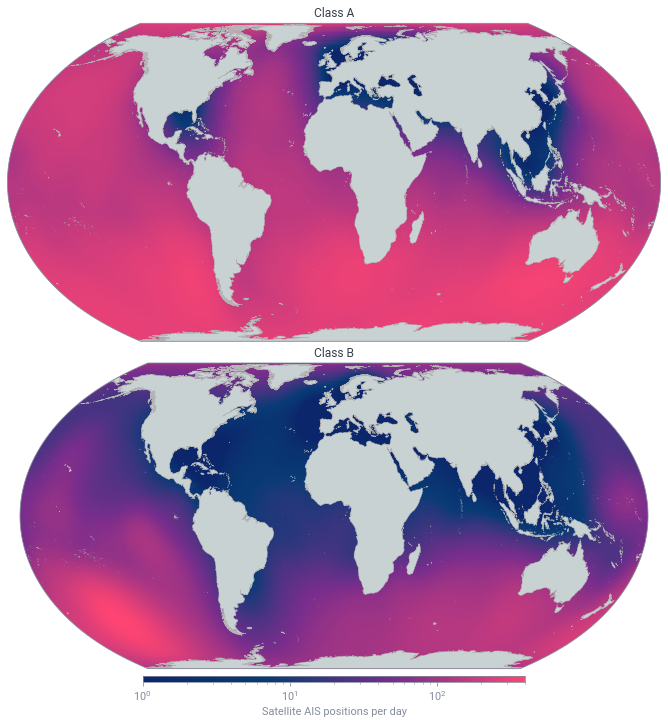

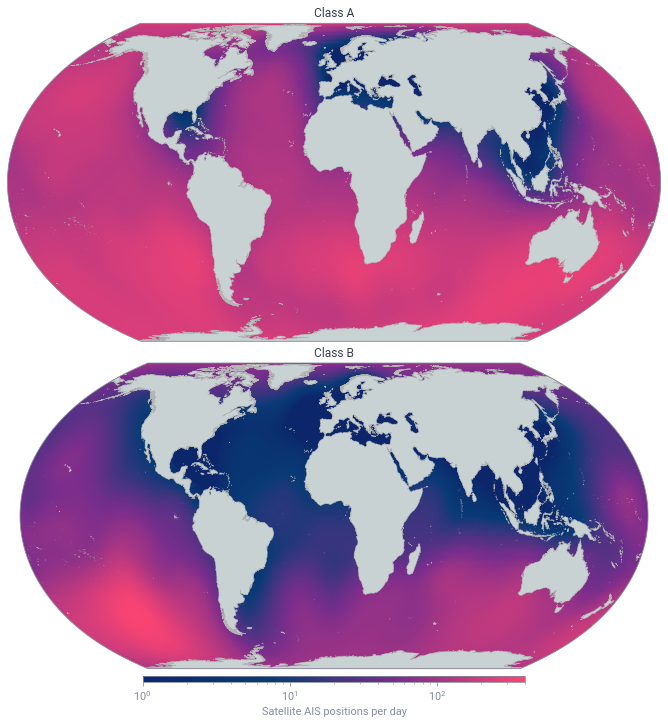

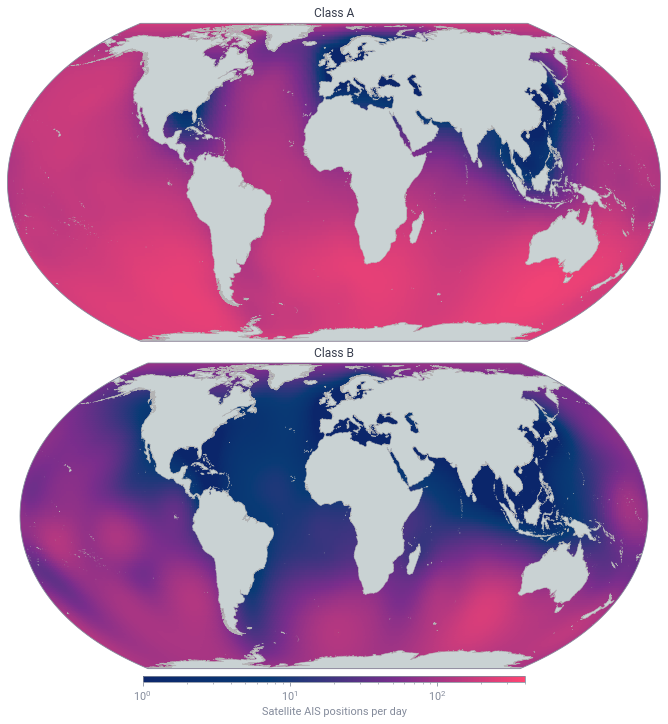

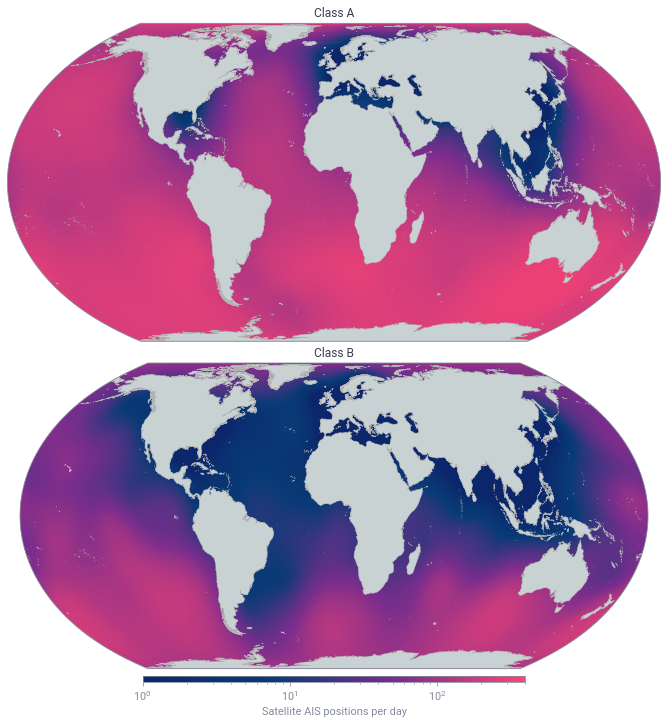

In [75]:
for r in reception_dates:
    print(str(r.date()))
    """
    Query smoothed reception data
    """
    month_reception_query = '''SELECT *
                               FROM `{d}.{t}`
                               WHERE _partitiontime = "{m}"'''.format(d = destination_dataset,
                                                                      t = sat_reception_smoothed,
                                                                      m = str(r.date())
                                                                     )
    # Query data
    month_reception = pd.read_gbq(month_reception_query, project_id='world-fishing-827', dialect='standard')
    
    utils.plot_reception_quality(reception_start_date = r,
                                 destination_dataset = destination_dataset,
                                 reception_smoothed_table = sat_reception_smoothed,
                                 reception_df = month_reception
                            )

Plot average reception quality across the full time series

/opt/miniconda3/envs/gfw/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/miniconda3/envs/gfw/lib/python3.8/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about servic

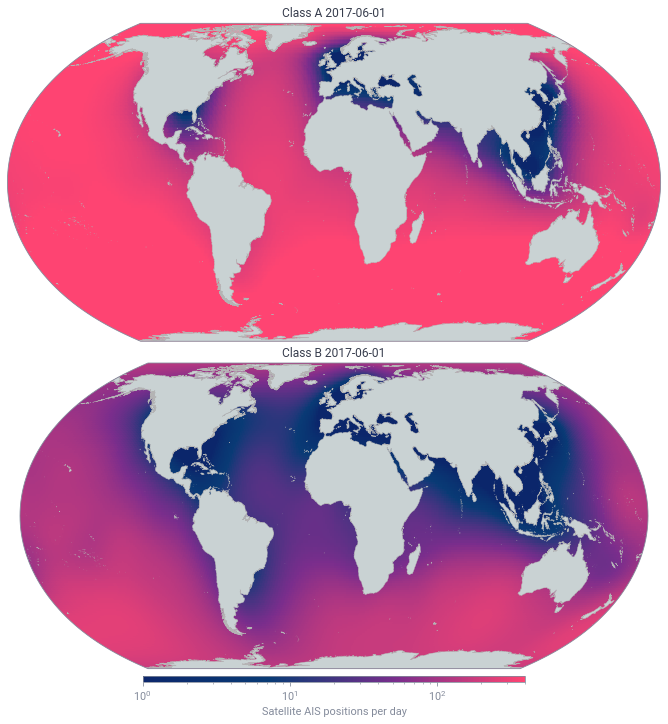

In [76]:
"""
Query smoothed reception data
"""
month_reception_query = '''SELECT 
                           lat_bin,
                           lon_bin,
                           class,
                           AVG(positions_per_day) as positions_per_day
                           FROM `{d}.{t}`
                           WHERE _partitiontime BETWEEN "2017-01-01" 
                           AND "2019-12-01"
                           GROUP BY 1,2,3'''.format(d = destination_dataset,
                                                      t = sat_reception_smoothed)
# Query data
month_reception = pd.read_gbq(month_reception_query, project_id='world-fishing-827', dialect='standard')

utils.plot_reception_quality(reception_start_date = r,
                             destination_dataset = destination_dataset,
                             reception_smoothed_table = sat_reception_smoothed,
                             reception_df = month_reception
                        )

## Final gap events table

Create the final gap events table that is used as an input to the model of suspected drivers of AIS disabling. This table takes the `ais_gap_events_vYYYYMMDD` table created above and adds a handful of additional model features, including the smoothed reception quality.

In [9]:
gap_events_features_table = 'ais_gap_events_features_{}'.format(output_version)
gap_events_features_table

'ais_gap_events_features_v20210722'

In [79]:
if create_tables:
    gap_features_tbl_cmd = "bq mk --schema=gaps/ais_gap_events_features.json \
    --time_partitioning_field=gap_start \
    --time_partitioning_type=DAY {}.{}".format(destination_dataset, 
                                               gap_events_features_table)
    os.system(gap_features_tbl_cmd)

In [85]:
gap_features_cmd = utils.make_ais_gap_events_features_table(pipeline_version=pipeline_version,
                                                   vi_version=vi_version,
                                                   output_version=output_version,
                                                   start_date=str(start_date),
                                                   end_date=str(end_date),
                                                   destination_dataset=destination_dataset,
                                                   destination_table=gap_events_features_table)

# gap_features_cmd

'jinja2 gaps/ais_gap_events_features.sql.j2     -D pipe_version="v20201001"     -D vi_version="v20210301"     -D output_version="v20210722"     -D start_date="2017-01-01"     -D end_date="2020-12-31"     -D destination_dataset="scratch_tyler"     |     bq query --replace     --destination_table=scratch_tyler.ais_gap_events_features_v20210722    --allow_large_results --use_legacy_sql=false --max_rows=0\n    '

In [87]:
# test query
# test_cmd = gap_features_cmd.split('|')[0]
# os.system(test_cmd)

0

In [88]:
# Run gap features query
# WARNING: BIG QUERY (~3.5 TB)
if create_tables:
    os.system(gap_features_cmd)

# Copy Tables

If needed, copy tables to a different BigQuery dataset.

In [14]:
# Copy destination dataset
cp_destination_dataset = 'proj_ais_gaps_catena'

# List of tables to copy
tables_to_cp = [
    off_events_table,
    on_events_table,
    gap_events_table,
    gap_events_features_table,
    loitering_events_table,
    gridded_loitering_table,
    fishing_table,
    ais_positions_hourly,
    sat_reception_measured,
    sat_reception_smoothed
]

if copy_tables:
    for t in tables_to_cp:

        print('Copying {d}.{t} \n to {cd}.{t}'.format(d = destination_dataset,
                                                  cd = cp_destination_dataset,
                                                  t = t))
        # Format query
        cp_cmd = """bq cp -n \
        {d}.{t} \
        {cd}.{t}""".format(d = destination_dataset,
                           cd = cp_destination_dataset,
                           t = t)

        # Run command
        os.system(cp_cmd)

Copying scratch_tyler.ais_off_events_v20210722 
 to proj_ais_gaps_catena.ais_off_events_v20210722
Copying scratch_tyler.ais_on_events_v20210722 
 to proj_ais_gaps_catena.ais_on_events_v20210722
Copying scratch_tyler.ais_gap_events_v20210722 
 to proj_ais_gaps_catena.ais_gap_events_v20210722
Copying scratch_tyler.ais_gap_events_features_v20210722 
 to proj_ais_gaps_catena.ais_gap_events_features_v20210722
Copying scratch_tyler.loitering_events_v20210722 
 to proj_ais_gaps_catena.loitering_events_v20210722
Copying scratch_tyler.gridded_loitering_v20210722 
 to proj_ais_gaps_catena.gridded_loitering_v20210722
Copying scratch_tyler.gridded_fishing_v20210722 
 to proj_ais_gaps_catena.gridded_fishing_v20210722
Copying scratch_tyler.ais_positions_byseg_hourly_v20210722 
 to proj_ais_gaps_catena.ais_positions_byseg_hourly_v20210722
Copying scratch_tyler.sat_reception_measured_one_degree_v20210722 
 to proj_ais_gaps_catena.sat_reception_measured_one_degree_v20210722
Copying scratch_tyler.sat_re

# Download data

Download the following datasets for us in the model to identify drivers of suspected disabling:
+ Gap events with features
+ Loitering events
+ Gridded fishing

In [36]:
# Create results folder 
results_dir = "../results"
# os.mkdir(results_dir)
# Create folder for specific results version
results_version_dir = os.path.join(results_dir, "gap_inputs_{}".format(output_version))
# os.mkdir(results_version_dir)

'../results/gap_inputs_v20210722'

In [17]:
%%bigquery gap_events_features_df
SELECT * 
FROM `world-fishing-827.scratch_tyler.ais_gap_events_features_v20210722` 
WHERE gap_hours >= 12
AND gap_start < '2021-01-01'

In [35]:
gap_events_features_df.to_csv('gap_events_features_{}.csv'.format(output_version), index = False)

Download loitering events:

In [37]:
%%bigquery loitering_events_df
SELECT *
FROM proj_ais_gaps_catena.loitering_events_v20210722

In [39]:
loitering_events_df.to_csv('{d}/loitering_events_v20210722.csv'.format(d = results_version_dir), index = False)

Gridded loitering

In [43]:
%%bigquery gridded_loitering_df
SELECT *
FROM proj_ais_gaps_catena.gridded_loitering_v20210722

In [49]:
gridded_loitering_df.to_csv('{d}/loitering_quarter_degree_v20210722_2017_to_2019.csv'.format(d = results_version_dir), index = False)

Download gridded fishing:

In [40]:
%%bigquery gridded_fishing_df
SELECT *
FROM proj_ais_gaps_catena.gridded_fishing_v20210722

In [42]:
gridded_fishing_df.to_csv('{d}/vessel_presence_quarter_degree_v20210722_2017_to_2019.csv'.format(d = results_version_dir), index = False)